### Comparison to fits

Let's demonstrate how well gaspery does compared to a fit on synthetic RV data. For this tutorial, we will use AU Mic b and a strategy of observing once every night for 30 nights. Specifically, we want to compare the expected value for $\sigma_K$ to the uncertainty on the retrieved K from the fit. 

This tutorial was initially based off the Fitting a Mean and Modeling Frameworks tutorials from DFM's tinygp documentation: https://tinygp.readthedocs.io/en/stable/tutorials/means.html

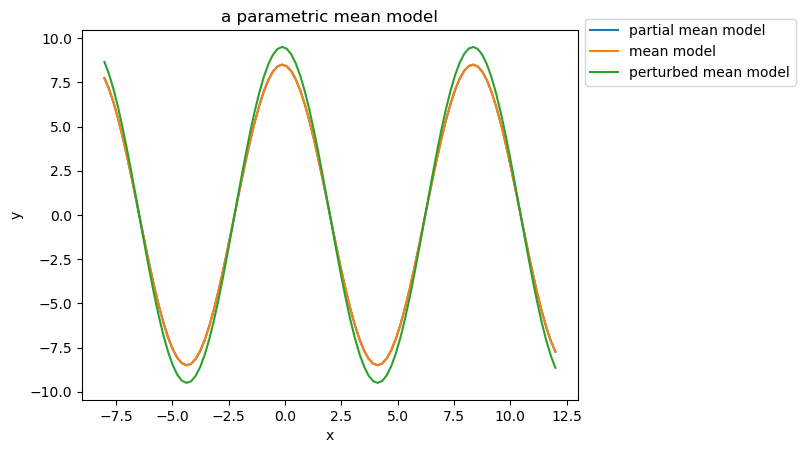

In [257]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import datetime
from numpy.linalg import inv, det, solve, cond

from gaspery import calculate_fi, strategies, utils
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

path = '/Users/chris/Desktop/gaspery/'

def mean_function(params, X):
    
    return -params['K'] * jnp.sin(2 * jnp.pi * (X - params['T0']) / params['p'])

### AU Mic b parameters from Klein+ 
K = 8.5
p = 8.46
T0 = 2458651.993 - 2458650
theta = [8.5, 8.46, T0]

mean_params = {
    "K": K,
    "p": p,
    "T0": T0}

# save in back pocket to troubleshoot for overfitting
perturbed_mean_params = {
    "K": K+1.,
    "p": p,
    "T0": T0}

X_grid = np.linspace(T0 - 10, T0 + 10, 100)
# in Dan's tutorial, partial(mean) instead of mean is used. why? 
model = jax.vmap(partial(mean_function, mean_params))(X_grid) 

plt.plot(X_grid, model, label='partial mean model')
plt.plot(X_grid, mean_function(mean_params, X_grid), label='mean model')
plt.plot(X_grid, mean_function(perturbed_mean_params, X_grid), label='perturbed mean model')

plt.xlabel("x")
plt.ylabel("y")
plt.legend(bbox_to_anchor=(1., 1.05))
_ = plt.title("a parametric mean model")


Strategy

In [258]:
n_obs = 30
start = T0
offs = []

strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))

Star

In [259]:
sigma_wn_rv = 5.
sigma_qp_rv = 47. #145 #47
Prot = 4.86
Tau = 110. # 30, 110
eta = 0.37

X = strat
# inject 20 random points in the time series and reserve for those to evaluate overfitting-ness
X_injected = np.concatenate((strat, (np.random.rand(1, 20)[0] * strat[-1]) + strat[0]), axis=0)
X_injectee = (np.random.rand(1, 20)[0] * strat[-1]) + strat[0]

Generate fake ground truth using the strategy, with 20 additional points, to use later for evaluation of overfitting by the MCMC. 

In [260]:
# instantiate GP object based on stellar activity kernel and strategy
gp_injected = GaussianProcess(kernel, X_injected) 

# draw one stellar signal as the "ground truth"
sample_injected = gp_injected.sample(jax.random.PRNGKey(4), shape=(1,)) 

# model planet model
planet_injected = calculate_fi.model_jax(X_injected, [theta[0], theta[1], theta[2]])

# combine simulated signals
observed_injected = sample_injected + planet_injected + random.normal(0, sigma_wn_rv, len(planet_injected))


In [261]:
injected_df = pd.DataFrame({'x': X_injected, 'y': observed_injected[0], 
                            'planet': planet_injected, 'star': sample_injected[0]})
injected_df = injected_df.sort_values(by=['x'])
not_injected = injected_df.loc[injected_df.x.isin(X)]
injected = injected_df.loc[~injected_df.x.isin(X)]

y = np.array(not_injected.y)

/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_16950/1814384255.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(not_injected.x, not_injected.y, yerr, fmt=".k", capsize=0, color='k', label='strategy')
/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_16950/1814384255.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(injected.x, injected.y, yerr, fmt=".k", capsize=0, color='r', label='injected')


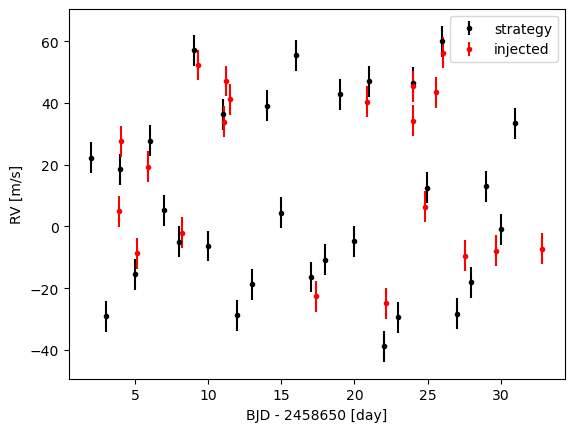

In [262]:
yerr = sigma_wn_rv

#plt.scatter(not_injected.x, not_injected.y, label='strategy')
#plt.scatter(injected.x, injected.y, label='injected')
plt.errorbar(not_injected.x, not_injected.y, yerr, fmt=".k", capsize=0, color='k', label='strategy')
plt.errorbar(injected.x, injected.y, yerr, fmt=".k", capsize=0, color='r', label='injected')

plt.xlabel("BJD - 2458650 [day]")
plt.ylabel("RV [m/s]")
plt.legend()
plt.show()

A note on error: for this tutorial, yerr, or scatter, is a measurement uncertainty. Therefore, in this case, yerr can also be sigma_wn_rv. Generally, we probably should have added an extra "jitter" term, sampled from some probably normal distribution, to represent intrinsic scatter. But here, since we know the error budget exactly, we can set jitter to zero and the error bars to be the same size. That is, we are asserting in this case that every observation has the same number of photons.


Let's now calculate the expected value on $\sigma_K$ using a Fisher Information-based approach. Then, we'll compare this value to the uncertainty on the K retrieved by an MCMC fit. Note that this is agnostic of the data itself -- gaspery just cares about the times, not the y-values.

In [263]:
# instantiate gaspery Star object in order to feed covariance matrix with white/correlated noise
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

#strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))
# calculate covariance matrix
sigma = star.cov_matrix_general(X, kernel)

# populate arguments for Fisher Info calculator
args = np.array(X), sigma, jnp.array(theta, dtype=float)

# calculate FI
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
sigma_k = np.sqrt(inv_fim)[0][0]
print("expected value of uncertainty on K: ", sigma_k, " m/s")


expected value of uncertainty on K:  1.3755791054158146  m/s


/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_16950/3658529363.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


Let's also create synthetic data for a more finely sampled strategy, for ease of assessment.

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


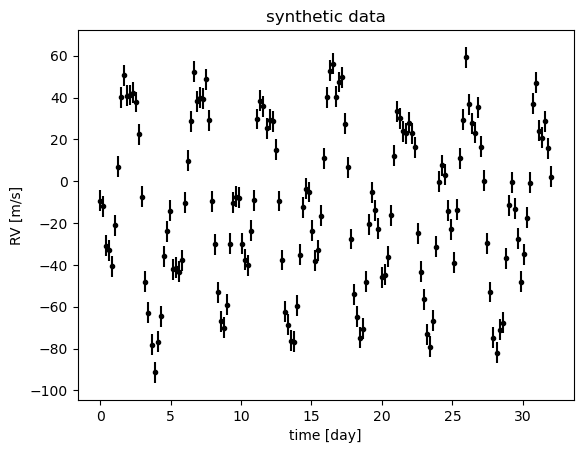

In [264]:
# for plotting convenience
t_plot = np.linspace(0, X[-1]+1, 150) # as opposed to X, or strat
gp_plot = GaussianProcess(kernel, t_plot) 
sample_plot = gp_plot.sample(jax.random.PRNGKey(4), shape=(1,))
planet_plot = calculate_fi.model_jax(t_plot, [theta[0], theta[1], theta[2]])
observed_plot = sample_plot + planet_plot + random.normal(0, sigma_wn_rv, len(t_plot)) 
y_plot = observed_plot[0]

plt.errorbar(t_plot, y_plot, np.ones(len(t_plot)) * sigma_wn_rv, fmt=".k", capsize=0)
plt.title('synthetic data')
plt.xlabel("time [day]")
plt.ylabel("RV [m/s]")
plt.show()

Framework for MCMC sampling, powered by numpyro

In [265]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def numpyro_model(t, y, yerr, hyperparams, theta):
    
    sigma_qp_rv = hyperparams[0]
    Prot = hyperparams[1]
    Tau = hyperparams[2]
    eta = hyperparams[3]
    
    K = theta[0]
    p = theta[1]
    T0 = theta[2]
    
    # sample hyperparameters using priors from Plavchan+ 2020, Table 1: https://arxiv.org/pdf/2006.13248.pdf
    #sigma_qp_rv = numpyro.sample("sigma_qp_rv", dist.Normal(sigma_qp_rv, 16)) #31./2))
    #Prot = numpyro.sample("Prot", dist.Normal(Prot, 0.01))
    #Tau = numpyro.sample("Tau", dist.TruncatedNormal(Tau, 30, low=0.)) # 110, 3
    #eta = numpyro.sample("eta", dist.Normal(eta, 0.02))
        
    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
    kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
    kernel *= sigma_qp_rv**2 # multiply by scalar
    
    # sample hyperparameters for planet mean model
    p = numpyro.sample("P", dist.Normal(p, 0.00004)) 
    K = numpyro.sample("K", dist.TruncatedNormal(K, 2.25, low=0.)) 
    T0 = numpyro.sample("T0", dist.Normal(T0, 1))
    mean_params = {"K": K, "P": p, "T0": T0}
        
    def mean_function(X):
        """
        Mean model is the planet's Keplerian.
        """

        return -mean_params['K'] * jnp.sin(2 * jnp.pi * (X - mean_params['T0']) / mean_params['P'])
    
    gp = GaussianProcess(kernel, t, diag=yerr**2, mean=mean_function) # mean_function
    #gp_plot = GaussianProcess(kernel, t_plot, diag=yerr**2, mean=mean_function)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    #numpyro.sample("gp_plot", gp_plot.numpyro_dist(), obs=y_plot)
    
    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc) 
        #numpyro.deterministic("pred-plot", gp_plot.condition(y_plot, t_plot).gp.loc)

nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000, # 1000
    num_samples=8000, # 5000
    num_chains=4,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)

/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_16950/2276662656.py:51: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Prep ingredients for numpyro sampling framework. Hyperparams are the stellar parameters; theta are the planet parameters.

In [266]:
hyperparams = [sigma_qp_rv, Prot, Tau, eta]
theta = [K, p, T0] 
perturbed_theta = [K+1., p, T0]

In [267]:
hyperparams, theta

([47.0, 4.86, 110.0, 0.37], [8.5, 8.46, 1.9929999997839332])

Run the MCMC

In [268]:
start = datetime.datetime.now()

mcmc.run(rng_key, t=np.array(not_injected.x), y=np.array(not_injected.y), yerr=sigma_wn_rv, # X, y vs t_plot, y_plot
         hyperparams=hyperparams, theta=theta) 
samples = mcmc.get_samples()
print(samples)

preds = samples["pred"].block_until_ready()  # Blocking to get timing right
#preds_plot = samples["pred-plot"].block_until_ready()  # Blocking to get timing right

end = datetime.datetime.now()
print("time elapsed: ", end-start)

sample: 100%|███████████████████████████████████████████████████| 9000/9000 [00:18<00:00, 490.31it/s, 71 steps of size 1.05e-02. acc. prob=0.96]


{'K': Array([10.2912375 , 10.6032787 , 10.61200712, ..., 11.45151149,
        8.35174629,  8.23434209], dtype=float64), 'P': Array([8.46000402, 8.46000352, 8.45997326, ..., 8.46005777, 8.46001306,
       8.46000173], dtype=float64), 'T0': Array([1.95962178, 1.98243576, 1.98352126, ..., 2.12637982, 1.86571276,
       1.84498576], dtype=float64), 'pred': Array([[ 20.30069783, -25.61909229,  18.42268935, ...,  13.24793921,
         -0.2657305 ,  34.6799426 ],
       [ 20.35760535, -25.72399929,  18.24165682, ...,  13.15533825,
         -0.44387361,  34.4828197 ],
       [ 20.36133707, -25.72588544,  18.23637619, ...,  13.15362552,
         -0.44887023,  34.47602635],
       ...,
       [ 20.95366028, -25.77800386,  17.73410799, ...,  13.1541557 ,
         -0.91677801,  33.62508417],
       [ 20.25868601, -24.81555378,  19.52129849, ...,  13.98914194,
          0.83381198,  35.66464492],
       [ 20.20970209, -24.78412937,  19.59886691, ...,  14.0142227 ,
          0.90867638,  35.76638757

Read out MCMC posteriors summary

In [269]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K,9.990,1.176,7.815,12.233,0.012,0.008,10293.0,10829.0,1.0
P,8.460,0.000,8.460,8.460,0.000,0.000,31181.0,22599.0,1.0
T0,2.023,0.180,1.675,2.355,0.002,0.001,10954.0,10208.0,1.0


In [270]:
K, p, T0

(8.5, 8.46, 1.9929999997839332)

Plot the trace!

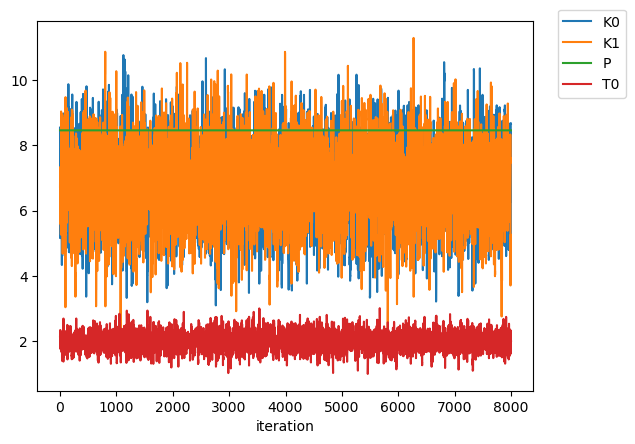

In [177]:
plt.plot(data.posterior.data_vars['K'][0], label='K0')
plt.plot(data.posterior.data_vars['K'][1], label='K1')

plt.plot(data.posterior.data_vars['P'][0], label='P')
plt.plot(data.posterior.data_vars['T0'][0], label='T0')
plt.xlabel('iteration')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

Time for corner plots!

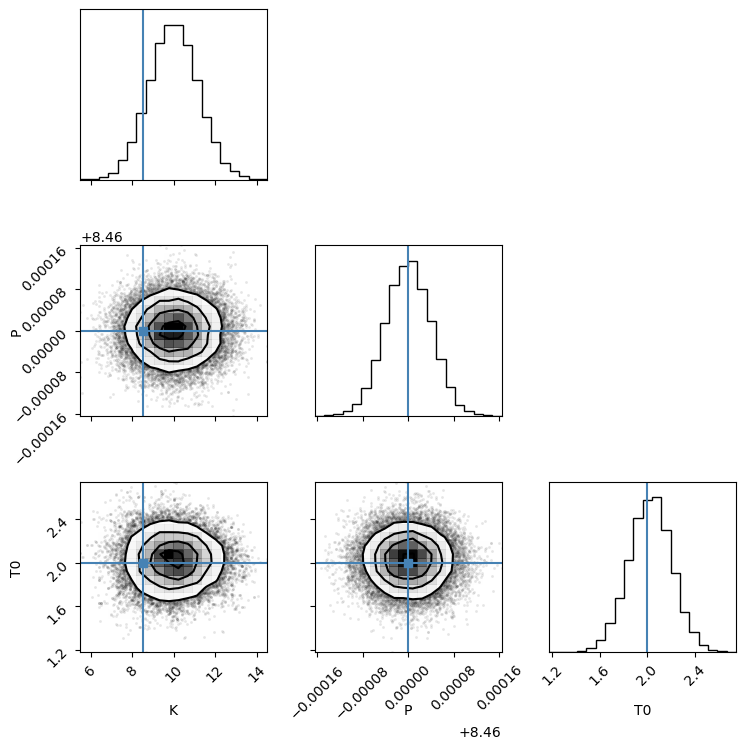

In [271]:
import corner 

#corner.corner(data, var_names=["K", "P", "T0", "sigma_qp_rv", "Prot", "Tau", "eta"], 
#              truths=[K, p, T0, sigma_qp_rv, Prot, Tau, eta])
corner.corner(data, var_names=["K", "P", "T0"], truths=[K, p, T0]);
plt.tight_layout()
plt.savefig(path+'plots/corner_30_obs_good.png')


Plot the posteriors! The first plot is with the 30-observation strategy; the second is with finer sampling to better diagnose what's going on.

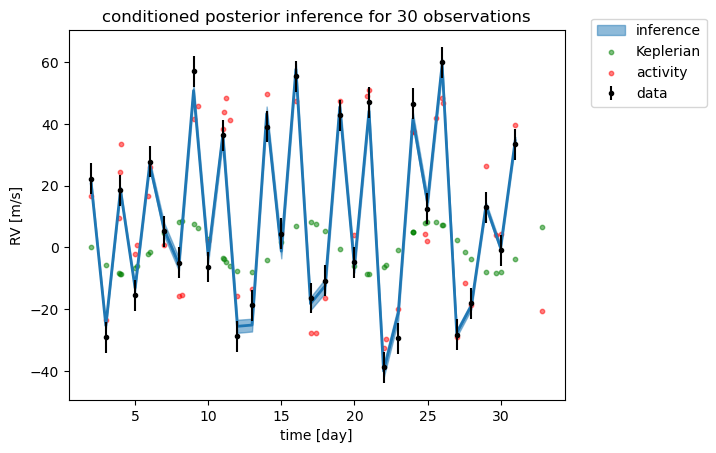

In [272]:
q = np.percentile(preds, [5, 50, 95], axis=0)
plt.fill_between(X, q[0], q[2], color="C0", alpha=0.5, label="inference")
plt.plot(X, q[1], color="C0", lw=2)

plt.errorbar(X, y, yerr,
             fmt=".k", capsize=0, label="data")

plt.scatter(X_injected, planet_injected, label="Keplerian", alpha=0.5, color="green", s=10)
plt.scatter(X_injected, sample_injected[0], label="activity", alpha=0.5, color="red", s=10)

plt.xlabel("time [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.3, 1.05))
_ = plt.title("conditioned posterior inference for 30 observations")
plt.savefig(path+'plots/breakdown_30_obs_good.png')

In [ ]:
preds_plot = samples["pred"].block_until_ready()  # pred-plot

q_plot = np.percentile(preds_plot, [5, 50, 95], axis=0)
plt.fill_between(t_plot, q_plot[0], q_plot[2], color="C0", alpha=0.5, label="inference")
plt.plot(t_plot, q_plot[1], color="C0", lw=2)

plt.errorbar(t_plot, y_plot, yerr,
             fmt=".k", capsize=0, label="data")

plt.plot(t_plot, planet_plot, label="Keplerian", alpha=0.5, color="green")
plt.plot(t_plot, sample_plot[0], label="activity", alpha=0.5, color="red")

plt.xlabel("BJD - 2458650 [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.3, 1.05))
_ = plt.title("posterior inference, finer sampling")
plt.savefig(path+'plots/breakdown_150_obs_bad.png')

Are the planet and stellar signals recovered by the best-fit posterior, and are we overfitting? 

In [273]:
### sample from best-fit planet posteriors
best_fit_planet = np.array([data.posterior.data_vars['K'].mean(), data.posterior.data_vars['P'].mean(), 
            data.posterior.data_vars['T0'].mean()])
best_fit_planet_std = np.array([data.posterior.data_vars['K'].std(), data.posterior.data_vars['P'].std(), 
            data.posterior.data_vars['T0'].std()])

planet_k = random.normal(best_fit_planet[0], best_fit_planet_std[0], len(sample))
planet_p = random.normal(best_fit_planet[1], best_fit_planet_std[1], len(sample))
planet_t0 = random.normal(best_fit_planet[2], best_fit_planet_std[2], len(sample))

planets = []
for i in range(len(sample)):
    planet = calculate_fi.model_jax(np.array(injected_df.x), [planet_k[i], planet_p[i], planet_t0[i]])
    planets.append(planet)


/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_16950/617634487.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax1.errorbar(not_injected.x, not_injected.planet, yerr, fmt=".k", capsize=0, color='k', label='planet training data')
/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_16950/617634487.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax1.errorbar(injected.x, injected.planet, yerr, fmt=".k", capsize=0, color='r', label='planet injected data')
/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_16950/617634487.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax3.errorbar(injected_df.x, observed_mean_planet 

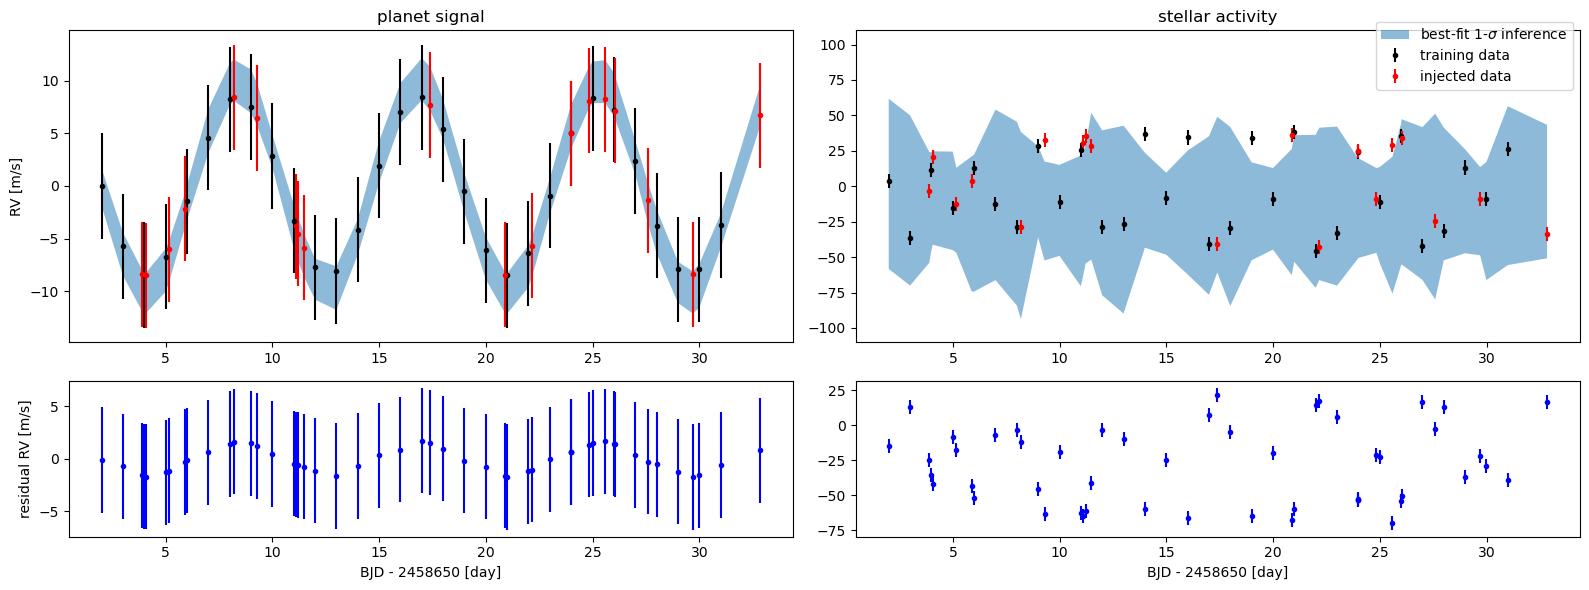

In [295]:
def mean_function_inference(params, X):
    
    return -params[0] * np.sin(2 * np.pi * (X - params[2]) / params[1])

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 6), height_ratios=[1, 0.5])

### best-fit 
best_fit_planet = np.array([data.posterior.data_vars['K'].mean(), data.posterior.data_vars['P'].mean(), 
            data.posterior.data_vars['T0'].mean()])
best_fit_planet_std = np.array([data.posterior.data_vars['K'].std(), data.posterior.data_vars['P'].std(), 
            data.posterior.data_vars['T0'].std()])
best_fit_star = np.array([sigma_qp_rv, Prot, Tau, eta])

# simulate stellar signal
kernel = kernels.ExpSineSquared(scale=best_fit_star[1], gamma=1/(2*best_fit_star[3]**2)) 
kernel *= kernels.ExpSquared(scale=best_fit_star[2]) 
kernel *= (best_fit_star[0])**2 

# instantiate GP object based on stellar activity kernel and strategy
gp = GaussianProcess(kernel, np.array(injected_df.x))

# draw ten stellar and planet signals based on best-fit parameters
sample = gp.sample(jax.random.PRNGKey(4), shape=(10,)) 

# add sampled planet signal and white noise
observed = sample + np.array(planets) + np.random.normal(0, sigma_wn_rv, len(planet))
observed_min = observed.min(axis=0)
observed_max = observed.max(axis=0)
observed_min_planet = np.array(planets).min(axis=0)
observed_max_planet = np.array(planets).max(axis=0)
observed_mean_planet = np.mean([observed_min_planet, observed_max_planet], axis=0)
observed_16_planet = observed_mean_planet - np.array(planets).std(axis=0)
observed_84_planet = observed_mean_planet + np.array(planets).std(axis=0)

observed_min_star = np.array(sample).min(axis=0)
observed_max_star = np.array(sample).max(axis=0)
observed_mean_star = np.mean([observed_min_star, observed_max_star], axis=0)
observed_16_star = observed_mean_star - np.array(sample).std(axis=0)
observed_84_star = observed_mean_star + np.array(sample).std(axis=0)

observed_mean_star = np.mean([np.array(sample).min(axis=0), np.array(sample).max(axis=0)], axis=0)

### planet
# injected signal used to generate data 
ax1.errorbar(not_injected.x, not_injected.planet, yerr, fmt=".k", capsize=0, color='k', label='planet training data')
ax1.errorbar(injected.x, injected.planet, yerr, fmt=".k", capsize=0, color='r', label='planet injected data')
# plot best-fit planet posteriors 
ax1.fill_between(np.array(injected_df.x), observed_min_planet, observed_max_planet, label="planet best-fit", alpha=0.5)

#ax1.set_xlabel("BJD - 2458650 [day]")
ax1.set_ylabel("RV [m/s]")
#ax1.legend(bbox_to_anchor=(1.35, 1.05))
_ = ax1.set_title("planet signal")

### planet residual
ax3.errorbar(injected_df.x, observed_mean_planet - injected_df.planet, 
             yerr, fmt=".k", capsize=0, color='blue', label='residual')
ax3.set_xlabel("BJD - 2458650 [day]")
ax3.set_ylabel("residual RV [m/s]")


### star
# injected signal used to generate data 
#ax2.plot(X, sample[0], label="star data", alpha=0.5, color="green")
ax2.errorbar(not_injected.x, not_injected.star - np.mean(injected_df.star), yerr, fmt=".k", capsize=0, color='k', label='training data')
ax2.errorbar(injected.x, injected.star - np.mean(injected_df.star), yerr, fmt=".k", capsize=0, color='r', label='injected data')
# plot best-fit star posteriors 
ax2.fill_between(np.array(injected_df.x), observed_16_star, observed_84_star, 
                 label=r"best-fit 1-$\sigma$ inference", alpha=0.5)
#ax2.plot(X, q[1] - mean_function_inference(best_fit, X), label="best-fit")

ax2.set_ylim([-110, 110])
#ax2.set_ylabel("RV [m/s]")
ax2.legend(bbox_to_anchor=(1., 1.05))
_ = ax2.set_title("stellar activity")


### star residual
ax4.errorbar(injected_df.x, observed_mean_star - injected_df.star, 
             yerr, fmt=".k", capsize=0, color='blue', label='residual')
ax4.set_xlabel("BJD - 2458650 [day]")

plt.tight_layout()
#plt.savefig(path+'plots/comparison_good_30_total_fit.png')
plt.show()

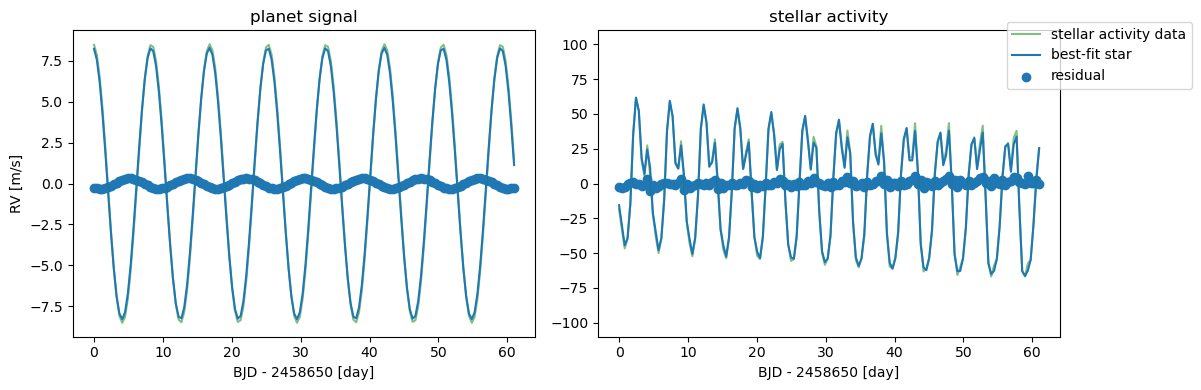

In [129]:
def mean_function_inference(params, X):
    
    return -params[0] * jnp.sin(2 * jnp.pi * (X - params[2]) / params[1])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

q = np.percentile(preds, [5, 50, 95], axis=0)

### planet
# injected signal used to generate data 
ax1.plot(t_plot, planet_plot, label="Keplerian data", alpha=0.5, color="green")
#ax1.plot(X, planet, label="Keplerian data", alpha=0.5, color="green")

# best-fit 
best_fit = np.array([data.posterior.data_vars['K'].mean(), data.posterior.data_vars['P'].mean(), 
            data.posterior.data_vars['T0'].mean()])
ax1.plot(t_plot, mean_function_inference(best_fit, t_plot), label="best-fit planet")
ax1.scatter(t_plot, mean_function_inference(best_fit, t_plot) - planet_plot, label='residual')
#ax1.plot(X, mean_function_inference(best_fit, X), label="best-fit")
#ax1.scatter(X, mean_function_inference(best_fit, X) - planet, label='residual')

ax1.set_xlabel("BJD - 2458650 [day]")
ax1.set_ylabel("RV [m/s]")
#ax1.legend(bbox_to_anchor=(1.35, 1.05))
_ = ax1.set_title("planet signal")

### star
# injected signal used to generate data 
ax2.plot(t_plot, sample_plot[0], label="stellar activity data", alpha=0.5, color="green")
#ax2.plot(X, sample[0], label="data", alpha=0.5, color="green")

# best-fit 
ax2.plot(t_plot, q[1] - mean_function_inference(best_fit, t_plot), label="best-fit star")
ax2.scatter(t_plot, sample_plot[0] - (q[1] - mean_function_inference(best_fit, t_plot)), label='residual')
#ax2.plot(X, q[1] - mean_function_inference(best_fit, X), label="best-fit")
#ax2.scatter(X, sample[0] - (q[1] - mean_function_inference(best_fit, X)), label='residual')

ax2.set_xlabel("BJD - 2458650 [day]")
ax2.set_ylim([-110, 110])
#ax2.set_ylabel("RV [m/s]")
ax2.legend(bbox_to_anchor=(1.3, 1.05))
_ = ax2.set_title("stellar activity")

plt.tight_layout()
plt.savefig(path+'plots/comparison_bad_150.png')
plt.show()

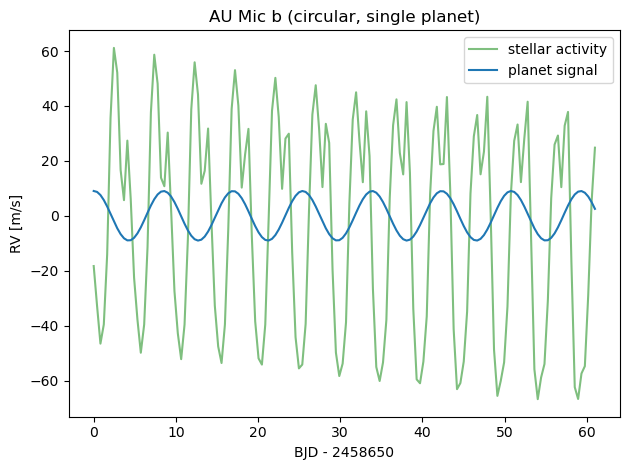

In [161]:
plt.plot(t_plot, sample_plot[0], label="stellar activity", alpha=0.5, color="green")
plt.plot(t_plot, mean_function_inference(best_fit, t_plot), label="planet signal")
plt.xlabel("BJD - 2458650")
plt.ylabel("RV [m/s]")
plt.legend()
plt.title("AU Mic b (circular, single planet)")
plt.tight_layout()
plt.savefig(path+"plots/comparison_for_slides.png", format='png')
plt.show()

Let's plot the residuals (data minus GP best-fit)

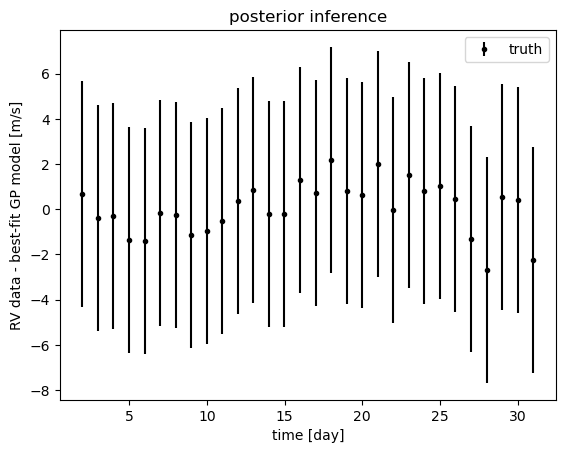

In [210]:
q = np.percentile(preds, [5, 50, 95], axis=0)
#plt.fill_between(X, q[0], q[2], color="C0", alpha=0.5, label="inference")
#plt.plot(X, q[1], color="C0", lw=2)

plt.errorbar(X, y - q[1], yerr,
             fmt=".k", capsize=0)
plt.xlabel("time [day]")
plt.ylabel("RV data - best-fit GP model [m/s]")
plt.legend()
_ = plt.title("posterior inference")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


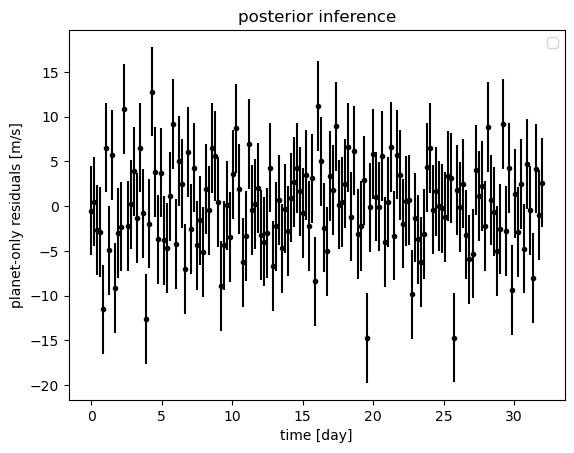

In [23]:
q_plot = np.percentile(preds_plot, [5, 50, 95], axis=0)
#plt.fill_between(t_plot, q_plot[0], q_plot[2], color="C0", alpha=0.5, label="inference")
#plt.plot(t_plot, q_plot[1], color="C0", lw=2)

plt.errorbar(t_plot, y_plot - q_plot[1], yerr,
             fmt=".k", capsize=0)
plt.xlabel("time [day]")
plt.ylabel("planet-only residuals [m/s]")
plt.legend()
_ = plt.title("posterior inference")